In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import time


In [11]:
imgs = ['ii1.png','ii2.png']

imgs = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in imgs]

# Initiate ORB detector
orb = cv2.ORB_create()
 
 
img_des = [orb.detectAndCompute(img) for img in imgs]
 
# draw keypoints on both images
imgs_kp_drawn = [
    cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0) 
    for img, kp in zip(imgs, img_des)
]

# Rotate both images by 90 degrees clockwise
imgs_kp_rotated = [
    cv2.rotate(img_kp_drawn, cv2.ROTATE_90_CLOCKWISE)
    for img_kp_drawn in imgs_kp_drawn
]

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, kp_img, title in zip(
    axs, imgs_kp_rotated, ['Image 1 Keypoints', 'Image 2 Keypoints']
):
    ax.imshow(kp_img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - Feature2D.detectAndCompute() missing required argument 'mask' (pos 2)
>  - Feature2D.detectAndCompute() missing required argument 'mask' (pos 2)


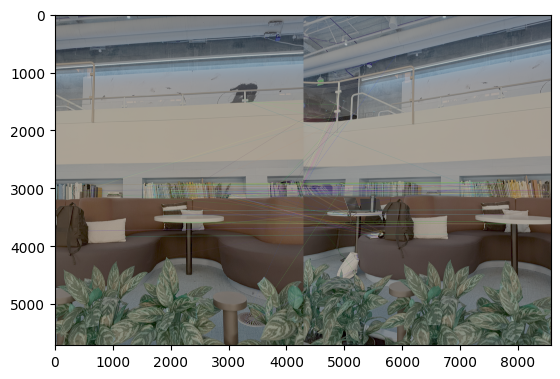

(<matplotlib.image.AxesImage at 0x16c0e6ed0>, None)

In [23]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('img3.png')          # queryImage
img2 = cv.imread('img4.png') # trainImage

# Rotate both images to portrait orientation (90 degrees clockwise)
# img1 = cv.rotate(img1, cv.ROTATE_90_CLOCKWISE)
# img2 = cv.rotate(img2, cv.ROTATE_90_CLOCKWISE)

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 20 matches.
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_DEFAULT)

plt.imshow(img3), plt.show()

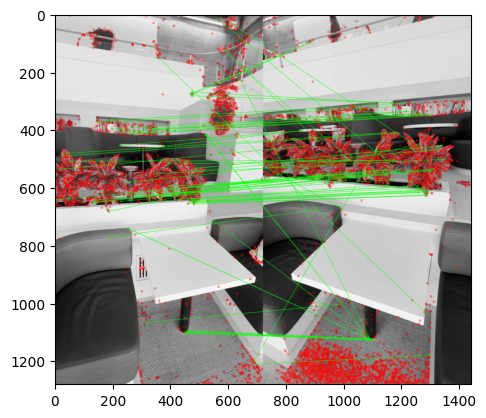

(<matplotlib.image.AxesImage at 0x1251ed150>, None)

In [18]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
 
img1 = cv.imread('ii1.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('ii2.png',cv.IMREAD_GRAYSCALE) # trainImage
 
# Rotate both images to portrait orientation (90 degrees clockwise)
img1 = cv.rotate(img1, cv.ROTATE_90_CLOCKWISE)
img2 = cv.rotate(img2, cv.ROTATE_90_CLOCKWISE)

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()